In [39]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches


In [40]:

def initgrid(L = 10, allup=False):

    M=np.zeros([L,L])
    for i in range(len(M)):
        for j in range(len(M)):
            ran=np.random.random()
            if(ran<0.5):
                M[i,j] = 1
            else:
                if allup==False:
                    M[i,j] = -1
                else:
                    M[i,j] = 1
    plt.figure(figsize=(6,6))
    values = np.unique(M.ravel())
    
    im = plt.imshow(M, interpolation='none')
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label="Spin {l}".format(l=values[i]) ) for i in range(len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    plt.title('Randomozed sipns on grid')
    plt.grid(True)
    plt.xticks(ticks=np.linspace(0,9,10))
    plt.yticks(ticks=np.linspace(0,9,10))

    plt.show()
    return M, L

In [41]:
def calcMagnetization(M):
    spin = 0
    for i in range(len(M)):
        for j in range(len(M)):
            if M[i,j]>0:
                spin = spin+1
            else:
                spin = spin-1
    return spin/len(M)**2

In [42]:
def isingmodel (
    n = 100,
    h = 1,
    J = 1, 
    kbT = 5
):
    M, L = initgrid(10,True)
    Energy = 0
    for i in range(L):
        for j in range (L):
            Sn = M[(i - 1) % L, j] + M[(i + 1) % L, j] + M[i, (j - 1) % L] + M[i, (j + 1) % L]   
            Energy += M[i,j]*(h+J*Sn)
    magnetization = []
    energyHistory = []
    prng = np.random.RandomState(12347890)
    for tstep in range(n):
        i=prng.randint(0,9)
        j=prng.randint(0,9)
        Sn = M[(i - 1) % L, j] + M[(i + 1) % L, j] + M[i, (j - 1) % L] + M[i, (j + 1) % L]
        dE=-2 * M[i,j] * (h + J * Sn)
        if dE<0 or prng.random()<np.exp(-dE/kbT):
            M[i,j] = -M[i,j]
            Energy+=dE
        energyHistory.append(Energy)
        magnetization.append(calcMagnetization(M))
        
    return energyHistory,M,n, magnetization
        

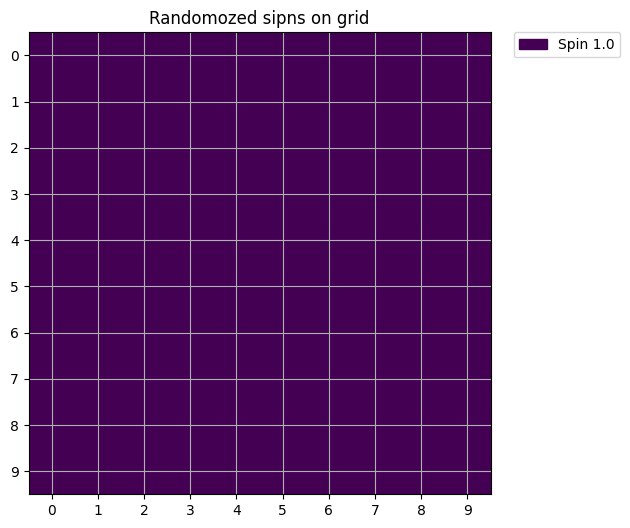

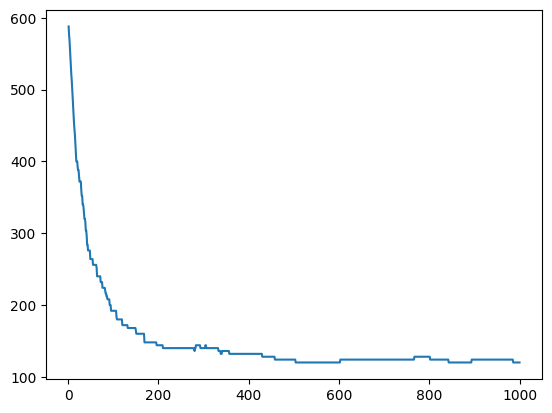

In [47]:

Data,M,n, magnetization=isingmodel(1000,2,1,1)
plt.plot(np.linspace(1,n,n),Data)


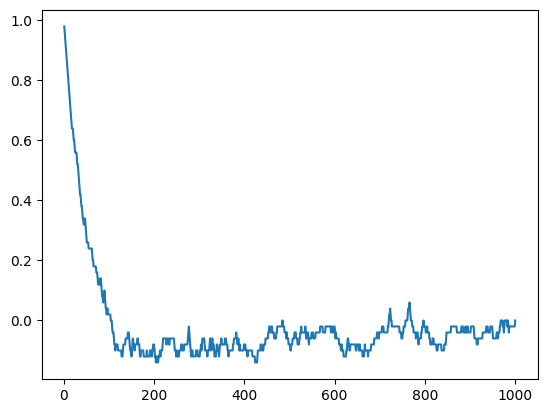

In [48]:
plt.plot(np.linspace(1,n,n), magnetization)